<a href="https://colab.research.google.com/github/V4IDIK/Project-Based-Learning-III/blob/main/Malaria_Detection_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import needed modules

In [ ]:
!pip install tensorflow==2.19.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.19.1 which is incompatible.


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Data Preprocessing

**Read data and store it in dataframe**

In [ ]:
!pip install kaggle

In [ ]:
import os
import json

# Ensure the .kaggle directory exists
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# Assuming kaggle.json was uploaded to the current working directory (usually /content/)
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 83% 563M/675M [00:03<00:01, 66.7MB/s]
100% 675M/675M [00:03<00:00, 206MB/s] 


In [ ]:
!unzip cell-images-for-detecting-malaria.zip

In [ ]:
# Generate data paths with labels
data_dir = '/content/cell_images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

**Split dataframe into train, valid, and test**

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [ ]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 22046 validated image filenames belonging to 2 classes.
Found 3306 validated image filenames belonging to 2 classes.
Found 2206 validated image filenames belonging to 2 classes.


**Show sample from train data**

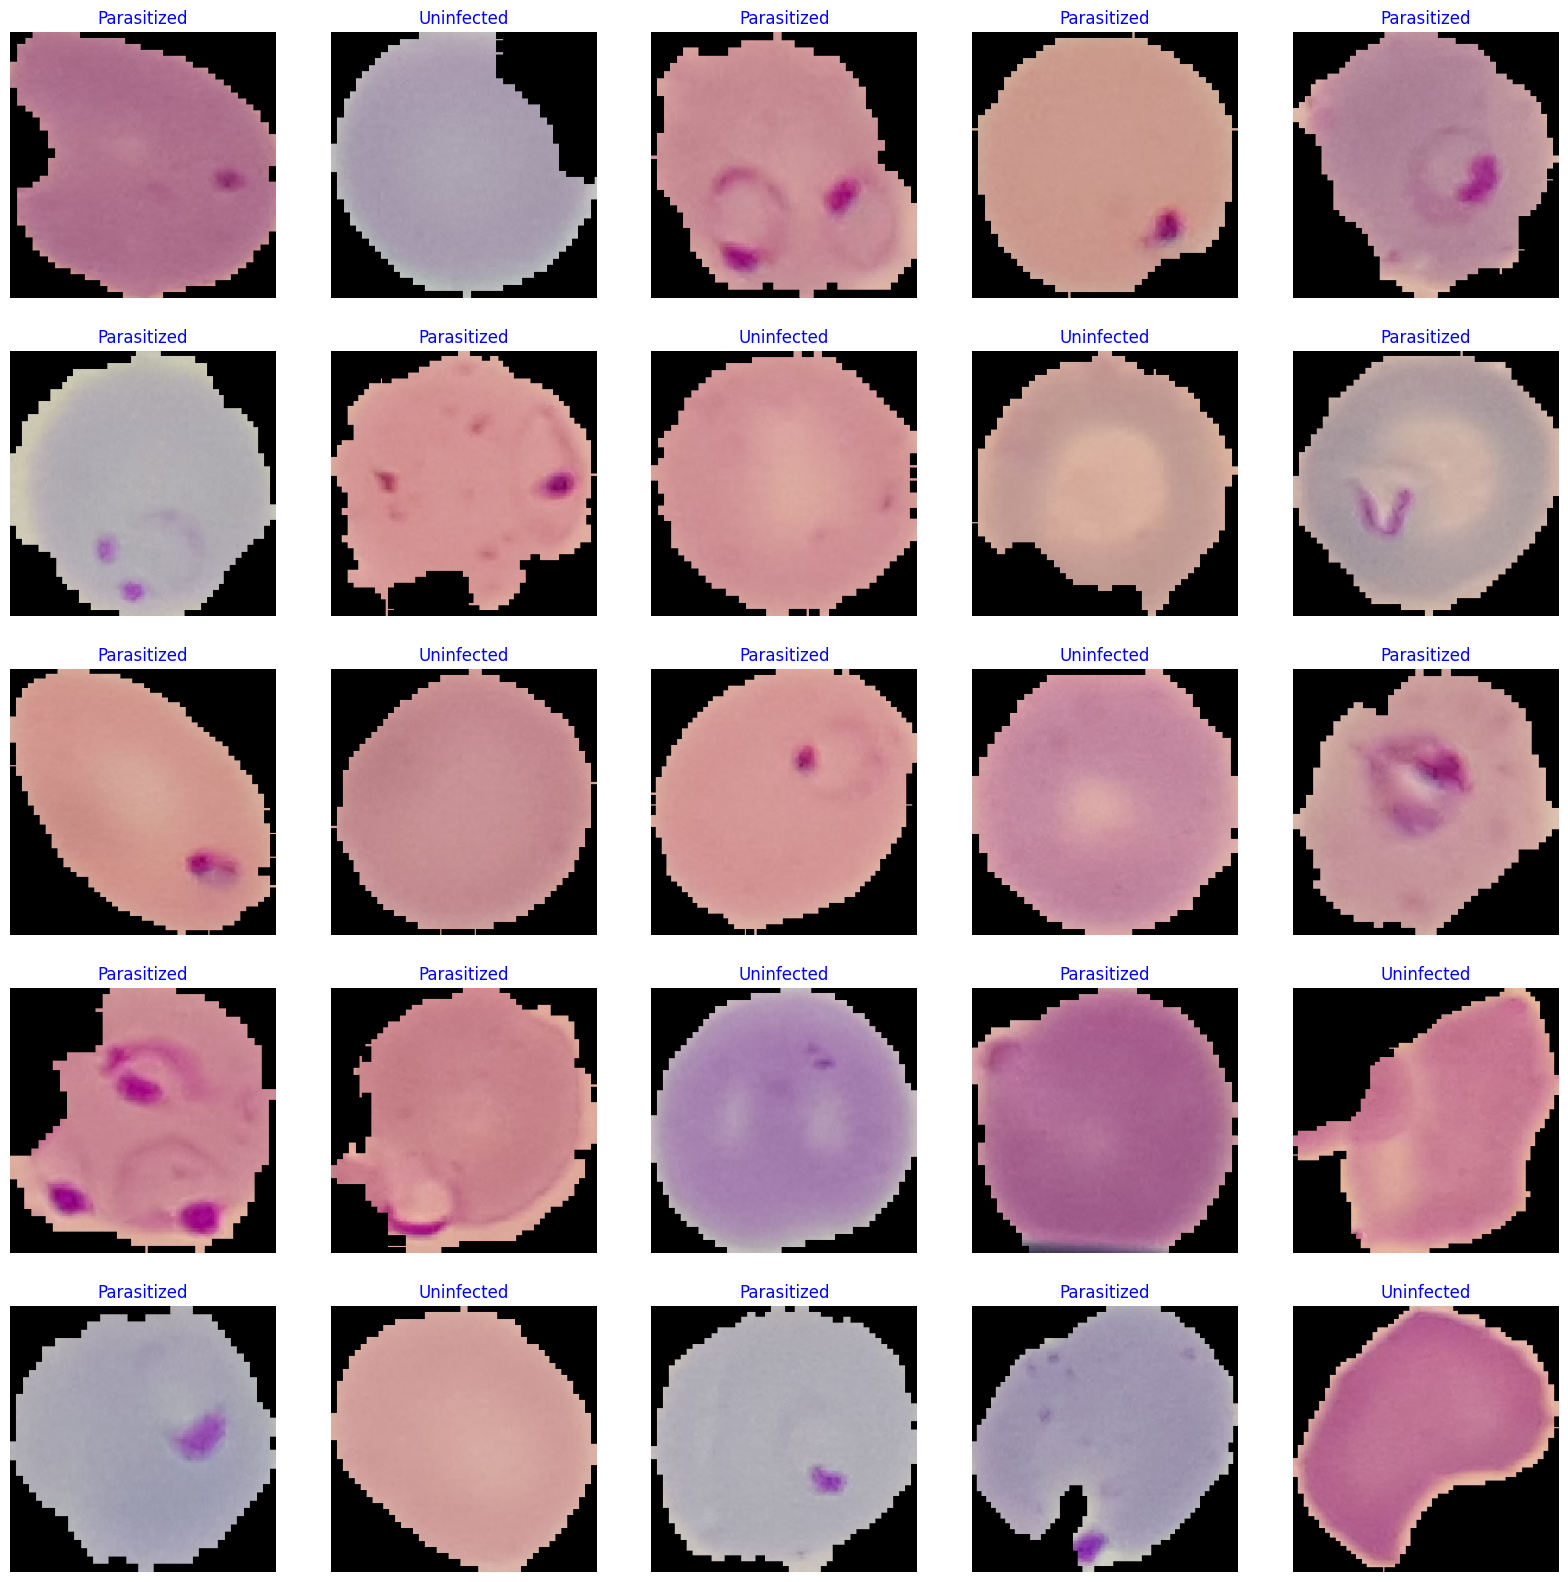

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l2= 0.016), activity_regularizer= regularizers.l1(l1=0.006),
                bias_regularizer= regularizers.l1(l1=0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

# Train model

In [ ]:
epochs = 5

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 415s 804ms/step - accuracy: 0.5407 - loss: 13.0353 - val_accuracy: 0.5023 - val_loss: 5.7457
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 174s 505ms/step - accuracy: 0.4968 - loss: 5.3444 - val_accuracy: 0.5213 - val_loss: 4.3892
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 174s 504ms/step - accuracy: 0.4999 - loss: 3.8757 - val_accuracy: 0.4950 - val_loss: 2.9614
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 174s 503ms/step - accuracy: 0.5040 - loss: 2.7431 - val_accuracy: 0.4995 - val_loss: 2.2694
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 173s 502ms/step - accuracy: 0.5038 - loss: 2.0524 - val_accuracy: 0.4959 - val_loss: 1.6752


**Display model performance**

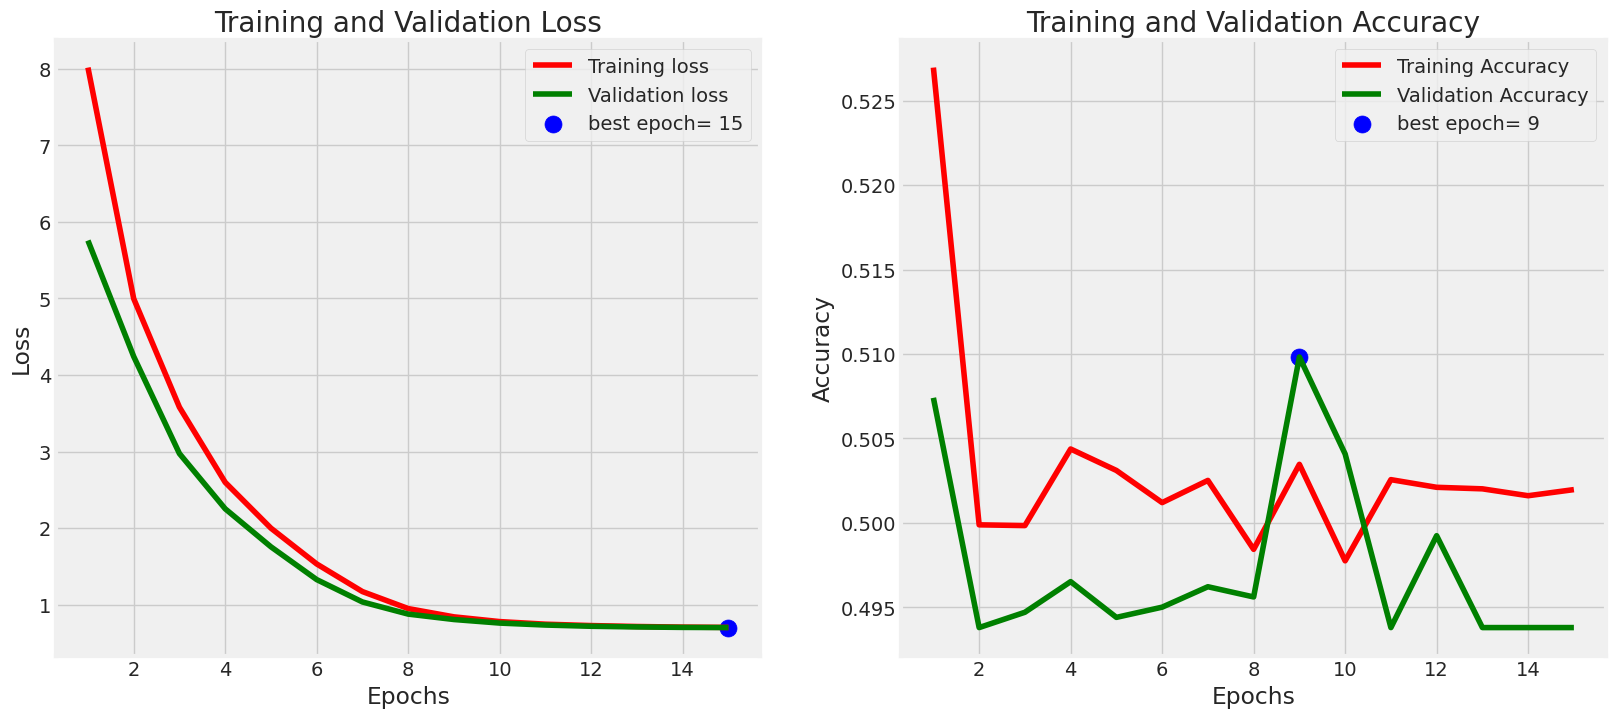

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 56s 50ms/step - accuracy: 0.5002 - loss: 0.7023  
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4938 - loss: 0.7023    
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.5144 - loss: 0.7019
Train Loss:  0.7023004293441772
Train Accuracy:  0.5014742612838745
--------------------
Validation Loss:  0.7022659182548523
Validation Accuracy:  0.4938010275363922
--------------------
Test Loss:  0.7020658254623413
Test Accuracy:  0.4945603013038635


**Get Predictions**

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step


**Confusion Matrics and Classification Report**

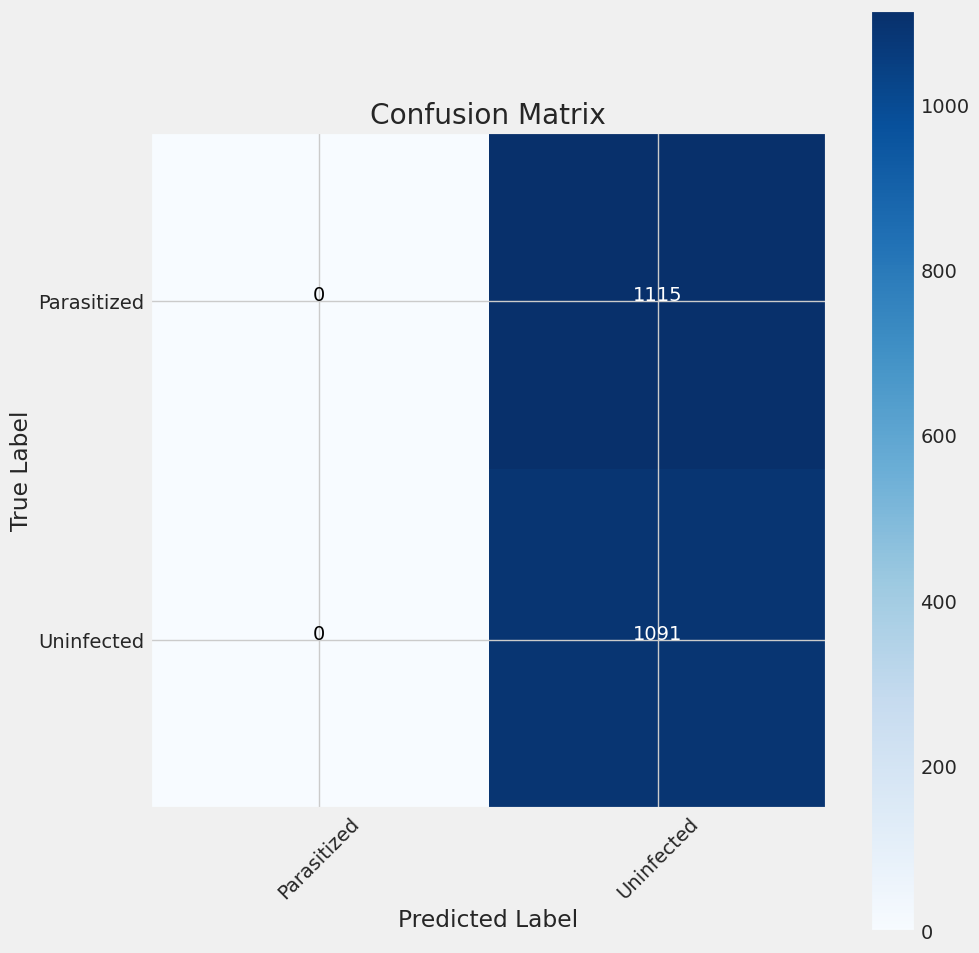

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00      1115
  Uninfected       0.49      1.00      0.66      1091

    accuracy                           0.49      2206
   macro avg       0.25      0.50      0.33      2206
weighted avg       0.24      0.49      0.33      2206



**Save model**

In [ ]:
#Save the model
model.save('Malaria Cells.keras')

# Prediction using loaded_model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/Malaria Cells.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Uninfected


# Task
Improve the accuracy of the malaria detection model from 0.5 to 0.9.

## Data augmentation

### Subtask:
Implement more aggressive data augmentation techniques during training to increase the diversity of the training data and prevent overfitting.


**Reasoning**:
Modify the ImageDataGenerator for training data to include more aggressive augmentation techniques and then recreate the data generators for train, validation, and test sets.



In [ ]:
# Modify the ImageDataGenerator for training data
tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Keep the ImageDataGenerator for validation and test data as is
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

# Recreate the data generators
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

Found 22046 validated image filenames belonging to 2 classes.
Found 3306 validated image filenames belonging to 2 classes.
Found 2206 validated image filenames belonging to 2 classes.


## Model architecture

### Subtask:
Explore different pre-trained model architectures or modify the current EfficientNetB3 model to better capture relevant features.


**Reasoning**:
Define a function to create a model using a pre-trained architecture and add a global average pooling layer followed by dense layers for classification, then instantiate and summarize the new model.



In [ ]:
def create_model(base_model_name, img_shape, class_count):
    """
    Creates a Keras model with a pre-trained base model and custom top layers.

    Args:
        base_model_name (str): The name of the pre-trained base model (e.g., 'VGG16', 'ResNet50').
        img_shape (tuple): The shape of the input images (height, width, channels).
        class_count (int): The number of output classes.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    if base_model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
    elif base_model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
    elif base_model_name == 'EfficientNetB3':
        base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(l2=0.016), activity_regularizer=regularizers.l1(l1=0.006),
              bias_regularizer=regularizers.l1(l1=0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the new model using ResNet50 as the base model
class_count = len(list(train_gen.class_indices.keys()))
new_model = create_model('ResNet50', img_shape, class_count)

# Print the summary of the new model
new_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,120,962 (92.01 MB)

 Trainable params: 24,063,746 (91.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

## Hyperparameter tuning

### Subtask:
Optimize hyperparameters such as learning rate, batch size, and number of epochs.


**Reasoning**:
I need to implement hyperparameter tuning to find the optimal learning rate and number of epochs for the model. I will use Keras Tuner for this purpose. I will define a function to build the model within Keras Tuner's framework and then use the RandomSearch tuner. For efficiency during tuning, I will use a smaller subset of the training data and a reduced number of epochs.



In [ ]:
!pip install keras-tuner

import keras_tuner as kt

def build_tuner_model(hp):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    class_count = len(list(train_gen.class_indices.keys()))

    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(l2=0.016), activity_regularizer=regularizers.l1(l1=0.006),
              bias_regularizer=regularizers.l1(l1=0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(Adamax(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_tuner_model,
    objective='val_accuracy',
    max_trials=5,  # Number of trials to run
    executions_per_trial=1, # Number of models to build and fit for each trial
    directory='my_dir', # Directory to save the search results
    project_name='malaria_tuning')

# Create a smaller subset of data for tuning
train_df_subset = train_df.sample(frac=0.1, random_state=123)
valid_df_subset = valid_df.sample(frac=0.1, random_state=123)

# Create data generators for the subsets
tr_gen_subset = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

ts_gen_subset = ImageDataGenerator(preprocessing_function=scalar)

train_gen_subset = tr_gen_subset.flow_from_dataframe(
    train_df_subset,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_subset = ts_gen_subset.flow_from_dataframe(
    valid_df_subset,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Run the tuner search
tuner.search(train_gen_subset,
             epochs=3, # Reduced number of epochs for tuning
             validation_data=valid_gen_subset)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 3 Complete [00h 04m 56s]
val_accuracy: 0.8368580341339111

Best val_accuracy So Far: 0.8368580341339111
Total elapsed time: 00h 15m 23s

The optimal learning rate for the optimizer is 0.0001.



**Reasoning**:
The previous step used Keras Tuner with a subset of data and a limited number of epochs to find the optimal learning rate. The output shows that a learning rate of 0.0001 yielded the best validation accuracy during the tuning process. Now, I need to train the model with this optimal learning rate using the full dataset and a larger number of epochs to get a more representative performance. I will update the model compilation with the best learning rate found and train it on the full training dataset for 10 epochs.

